In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    threshold = 2
    num_split = 10
    bert_feat_columns = ['name', 'categories']
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']
    recall_columns = ['name', 'address', 'categories', 'address', 'phone']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_simple(df, threshold):
    val2id_d = {}
    for col in CFG.recall_columns:
        temp_df = df[['id', col]]
        temp_df[col] = temp_df[col].str.lower()
        val2id = temp_df.groupby(col)['id'].apply(set).to_dict()
        val2id_d[col] = val2id
        del val2id
    
    cus_ids = []
    match_ids = []
    for vals in tqdm(df[CFG.recall_columns + ['id']].fillna('null').values):
        cus_id = vals[-1]
        match_id = []
        
        rec_match_count = []
        for i in range(len(CFG.recall_columns)):
            col = CFG.recall_columns[i]
            
            if vals[i] != 'null':
                rec_match_count += list(val2id_d[col][vals[i].lower()])
        rec_match_count = dict(Counter(rec_match_count))
        
        for k, v in rec_match_count.items():
            if v > threshold:
                match_id.append(k)
        
        cus_ids += [cus_id] * len(match_id)
        match_ids += match_id
    
    train_df = pd.DataFrame()
    train_df['id'] = cus_ids
    train_df['match_id'] = match_ids
    train_df = train_df.drop_duplicates()
    del cus_ids, match_ids
    
    num_data = len(train_df)
    num_data_per_id = num_data / train_df['id'].nunique()
    print('Num of data: %s' % num_data)
    print('Num of data per id: %s' % num_data_per_id)
    
    return train_df

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest', 'fold']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [ ]:
def add_features(df):
    for col in tqdm(CFG.feat_columns):
        if col in CFG.bert_feat_columns:
            col_values = data.loc[df['id']][col].fillna("null").values.astype(str)
            matcol_values = data.loc[df['match_id']][col].fillna("null").values.astype(str)
            bert_sim = []
            for s, match_s in zip(col_values, matcol_values):
                if s == 'null' or match_s == 'null':
                    bert_sim.append(0)
                else:
                    bert_sim.append(cos_sim(bert_d[col][s], bert_d[col][match_s]))
            df[f'{col}_bert_sim'] = bert_sim
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        if not col in ['url']:
            col_values = data.loc[df['id']][col].values.astype(str)
            matcol_values = data.loc[df['match_id']][col].values.astype(str)
            
            geshs = []
            levens = []
            jaros = []
            lcss = []
            for s, match_s in zip(col_values, matcol_values):
                if s != 'nan' and match_s != 'nan':                    
                    geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                    levens.append(Levenshtein.distance(s, match_s))
                    jaros.append(Levenshtein.jaro_winkler(s, match_s))
                    lcss.append(LCS(str(s), str(match_s)))
                else:
                    geshs.append(np.nan)
                    levens.append(np.nan)
                    jaros.append(np.nan)
                    lcss.append(np.nan)
            
            df[f'{col}_gesh'] = geshs
            df[f'{col}_leven'] = levens
            df[f'{col}_jaro'] = jaros
            df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])

        if col not in ['phone', 'zip', 'url']:
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training fold']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=CFG.num_split, seed=CFG.SEED)):
    data.loc[val_ind, "fold"] = set_ind
    
    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development fold - fold {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation fold - fold {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training fold,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 0,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 0,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 1,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 2,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 2,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 3,37.32%,48.77%,6.38%,2.09%,5.44%
validation fold - fold 3,37.32%,48.77%,6.38%,2.09%,5.44%
development fold - fold 4,37.32%,48.77%,6.38%,2.09%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['fold'].value_counts())

train_data = data[data['fold'].isin([i for i in range(CFG.num_split // 2)])]
test_data = data[~data['fold'].isin([i for i in range(CFG.num_split // 2)])]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
1.0    113887
0.0    113887
2.0    113882
3.0    113882
5.0    113881
4.0    113881
6.0    113881
8.0    113877
9.0    113877
7.0    113877
Name: fold, dtype: int64
Train data: 
Num of data: 569419
Num of unique id: 569419
Num of unique poi: 369990
Mean num of unique poi: 1.5390118651855456
Test data: 
Num of data: 569393
Num of unique id: 569393
Num of unique poi: 369982
Mean num of unique poi: 1.5389748690476834
set()
set()


In [ ]:
bert_d = {}
for col in CFG.bert_feat_columns:
    with open(os.path.join(CFG.DATASET_DIR, col + "_bert_vec.pkl"), "rb") as f:
        bert_d[col] = pickle.load(f)

In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data.loc[data['fold'].isin([i for i in range(CFG.num_split // 2)]), col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data_simple = recall_simple(data.loc[data['fold'].isin([i for i in range(CFG.num_split // 2)])], CFG.threshold)
train_data = recall_knn(data.loc[data['fold'].isin([i for i in range(CFG.num_split // 2)])], CFG.num_neighbors)

print('train data by knn: %s' % len(train_data))
train_data = train_data.merge(train_data_simple,
                             on = ['id', 'match_id'],
                             how = 'outer')
del train_data_simple
gc.collect()

test_data_simple = recall_simple(data.loc[~data['fold'].isin([i for i in range(CFG.num_split // 2)])], CFG.threshold)
test_data = recall_knn(data.loc[~data['fold'].isin([i for i in range(CFG.num_split // 2)])], CFG.num_neighbors)

print('test data by knn: %s' % len(test_data))
test_data = test_data.merge(test_data_simple,
                             on = ['id', 'match_id'],
                             how = 'outer')
del test_data_simple
gc.collect()

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

  0%|          | 0/569419 [00:00<?, ?it/s]

Num of data: 1732574
Num of data per id: 4.64479617387015
Start knn grouped by country


  0%|          | 0/210 [00:00<?, ?it/s]

Start knn
train data by knn: 13922913


  0%|          | 0/569393 [00:00<?, ?it/s]

Num of data: 1666008
Num of data per id: 4.4637808524548
Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
test data by knn: 13925359
Num of unique id: 569419
Num of train data: 15213764
Pos rate: 0.06670827810921742
                        id          match_id     kdist  kneighbors  \
12178284  E_387cd64c624af0  E_9eec6072bc4cbf       NaN         NaN   
2889224   E_12d9de853aa5b4  E_e8cff5ff4b7e49  0.020266         5.0   
11039035  E_62e545b088c54b  E_e0059fe92a96ce  0.012919        19.0   
10309558  E_1ae759ac05cbc6  E_b047b2bb37af38  0.001234        18.0   
5465350   E_991af798f149bf  E_bbf94ad5c0e17f  0.008392         9.0   

         point_of_interest  fold  kdist_country  kneighbors_country  \
12178284  P_5a6a09b1fae48e   2.0       0.000784                15.0   
2889224                NaN   NaN            NaN                 NaN   
11039035               NaN   NaN            NaN                 NaN   
10309558  P_1e9c45382a6b23   3.0       0.001234                18.0   
5465350   P_c433c83c07ed82   3.0       0.008324                 9.0   

          kdist_diff  kneighbors

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9276347714624148


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in CFG.bert_feat_columns:
    features += [c + '_bert_sim']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    if not c in ['url']:
        features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c == 'url':
        features += [f"{c}_len_diff", f"{c}_sim"]
    if c in ['address', 'categories', 'country', 'name', 'state']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

66
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_bert_sim', 'categories_bert_sim', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_len_diff', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categor

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0488687
[100]	valid_0's binary_logloss: 0.0468708
[150]	valid_0's binary_logloss: 0.0460353
[200]	valid_0's binary_logloss: 0.0455248
[250]	valid_0's binary_logloss: 0.0452106
[300]	valid_0's binary_logloss: 0.0450104
[350]	valid_0's binary_logloss: 0.0446909
[400]	valid_0's binary_logloss: 0.0444956
[450]	valid_0's binary_logloss: 0.0443411
[500]	valid_0's binary_logloss: 0.0441856
[550]	valid_0's binary_logloss: 0.0440562
[600]	valid_0's binary_logloss: 0.0439988
[650]	valid_0's binary_logloss: 0.0439219
[700]	valid_0's binary_logloss: 0.0438275
[750]	valid_0's binary_logloss: 0.0437359
[800]	valid_0's binary_logloss: 0.0436582
[850]	valid_0's binary_logloss: 0.043583
[900]	valid_0's binary_logloss: 0.043528
[950]	valid_0's binary_logloss: 0.0434465
[1000]	valid_0's binary_logloss: 0.0433813
[1050]	valid_0's binary_logloss: 0.0433131
[1100]	valid_0's binary_logloss: 0.0432535
[1150]	valid_0's binary_logloss: 0.0432089
[1200]	valid_0's binary_logloss: 

In [ ]:
del train_data
gc.collect()

85

#Check Feature Importances

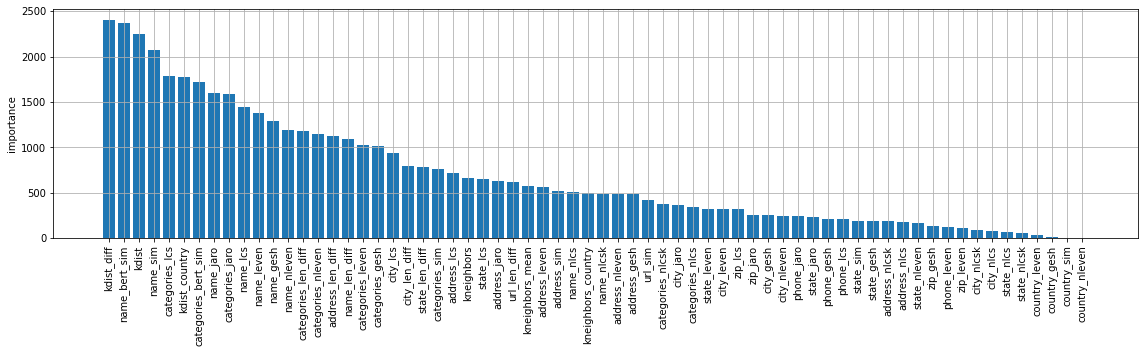

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-06-04 17:20:04,649] A new study created in memory with name: no-name-3250939e-9367-4869-a887-8369303af046
[I 2022-06-04 17:20:43,045] Trial 0 finished with value: 0.833501257282124 and parameters: {'threshold': 0.6152990592010742}. Best is trial 0 with value: 0.833501257282124.


CV: 0.833501


[I 2022-06-04 17:21:02,808] Trial 1 finished with value: 0.8298357476658736 and parameters: {'threshold': 0.7033245855344828}. Best is trial 0 with value: 0.833501257282124.


CV: 0.829836


[I 2022-06-04 17:21:23,133] Trial 2 finished with value: 0.8163586662870556 and parameters: {'threshold': 0.826060767438958}. Best is trial 0 with value: 0.833501257282124.


CV: 0.816359


[I 2022-06-04 17:21:42,432] Trial 3 finished with value: 0.8155297037846614 and parameters: {'threshold': 0.8307758976406614}. Best is trial 0 with value: 0.833501257282124.


CV: 0.815530


[I 2022-06-04 17:22:01,824] Trial 4 finished with value: 0.7489231381157198 and parameters: {'threshold': 0.9702683166821702}. Best is trial 0 with value: 0.833501257282124.


CV: 0.748923


[I 2022-06-04 17:22:20,816] Trial 5 finished with value: 0.8020999021526144 and parameters: {'threshold': 0.887218835221228}. Best is trial 0 with value: 0.833501257282124.


CV: 0.802100


[I 2022-06-04 17:22:42,051] Trial 6 finished with value: 0.8320835680353389 and parameters: {'threshold': 0.4547591562067439}. Best is trial 0 with value: 0.833501257282124.


CV: 0.832084


[I 2022-06-04 17:23:03,066] Trial 7 finished with value: 0.8324613287993969 and parameters: {'threshold': 0.46484543013443147}. Best is trial 0 with value: 0.833501257282124.


CV: 0.832461


[I 2022-06-04 17:23:24,342] Trial 8 finished with value: 0.8279054518839748 and parameters: {'threshold': 0.3828703320301695}. Best is trial 0 with value: 0.833501257282124.


CV: 0.827905


[I 2022-06-04 17:23:45,142] Trial 9 finished with value: 0.8336528875180329 and parameters: {'threshold': 0.6084218053939094}. Best is trial 9 with value: 0.8336528875180329.


CV: 0.833653


[I 2022-06-04 17:24:07,225] Trial 10 finished with value: 0.7558689766881553 and parameters: {'threshold': 0.08921850443368229}. Best is trial 9 with value: 0.8336528875180329.


CV: 0.755869


[I 2022-06-04 17:24:41,103] Trial 11 finished with value: 0.833199621649046 and parameters: {'threshold': 0.6303755255781291}. Best is trial 9 with value: 0.8336528875180329.


CV: 0.833200


[I 2022-06-04 17:25:02,588] Trial 12 finished with value: 0.8146514113630344 and parameters: {'threshold': 0.26703949305538754}. Best is trial 9 with value: 0.8336528875180329.


CV: 0.814651


[I 2022-06-04 17:25:23,415] Trial 13 finished with value: 0.8315975536081245 and parameters: {'threshold': 0.6732887827969735}. Best is trial 9 with value: 0.8336528875180329.


CV: 0.831598


[I 2022-06-04 17:25:44,616] Trial 14 finished with value: 0.8338216873747427 and parameters: {'threshold': 0.5984651188621319}. Best is trial 14 with value: 0.8338216873747427.


CV: 0.833822


[I 2022-06-04 17:26:05,392] Trial 15 finished with value: 0.8173233144931047 and parameters: {'threshold': 0.28344703586204667}. Best is trial 14 with value: 0.8338216873747427.


CV: 0.817323


[I 2022-06-04 17:26:26,383] Trial 16 finished with value: 0.8340360791785548 and parameters: {'threshold': 0.5473895365588546}. Best is trial 16 with value: 0.8340360791785548.


CV: 0.834036


[I 2022-06-04 17:26:50,735] Trial 17 finished with value: 0.731363556391545 and parameters: {'threshold': 0.061832631743763855}. Best is trial 16 with value: 0.8340360791785548.


CV: 0.731364


[I 2022-06-04 17:27:10,809] Trial 18 finished with value: 0.8340315078883984 and parameters: {'threshold': 0.5340920637499926}. Best is trial 16 with value: 0.8340360791785548.


CV: 0.834032


[I 2022-06-04 17:27:32,551] Trial 19 finished with value: 0.8189185964152096 and parameters: {'threshold': 0.2946553162462221}. Best is trial 16 with value: 0.8340360791785548.


CV: 0.818919


[I 2022-06-04 17:27:53,904] Trial 20 finished with value: 0.7946732143384246 and parameters: {'threshold': 0.17565877805190405}. Best is trial 16 with value: 0.8340360791785548.


CV: 0.794673


[I 2022-06-04 17:28:14,942] Trial 21 finished with value: 0.83401325085833 and parameters: {'threshold': 0.5282645318788749}. Best is trial 16 with value: 0.8340360791785548.


CV: 0.834013


[I 2022-06-04 17:28:36,212] Trial 22 finished with value: 0.8337588365287503 and parameters: {'threshold': 0.5101935198871808}. Best is trial 16 with value: 0.8340360791785548.


CV: 0.833759


[I 2022-06-04 17:28:56,302] Trial 23 finished with value: 0.8337432965737029 and parameters: {'threshold': 0.5105654876566019}. Best is trial 16 with value: 0.8340360791785548.


CV: 0.833743


[I 2022-06-04 17:29:16,724] Trial 24 finished with value: 0.826219158964412 and parameters: {'threshold': 0.7489994246181207}. Best is trial 16 with value: 0.8340360791785548.


CV: 0.826219


[I 2022-06-04 17:29:38,140] Trial 25 finished with value: 0.8280954511814622 and parameters: {'threshold': 0.38631427782263483}. Best is trial 16 with value: 0.8340360791785548.


CV: 0.828095


[I 2022-06-04 17:29:59,131] Trial 26 finished with value: 0.8340387765791243 and parameters: {'threshold': 0.5493060590481857}. Best is trial 26 with value: 0.8340387765791243.


CV: 0.834039


[I 2022-06-04 17:30:19,403] Trial 27 finished with value: 0.8284207343267314 and parameters: {'threshold': 0.3909966073839236}. Best is trial 26 with value: 0.8340387765791243.


CV: 0.828421


[I 2022-06-04 17:30:40,155] Trial 28 finished with value: 0.8273875751955931 and parameters: {'threshold': 0.7367435360960112}. Best is trial 26 with value: 0.8340387765791243.


CV: 0.827388


[I 2022-06-04 17:30:59,858] Trial 29 finished with value: 0.8338668559318986 and parameters: {'threshold': 0.5822167074942743}. Best is trial 26 with value: 0.8340387765791243.


CV: 0.833867


[I 2022-06-04 17:31:20,738] Trial 30 finished with value: 0.8309267576710696 and parameters: {'threshold': 0.43115662827884105}. Best is trial 26 with value: 0.8340387765791243.


CV: 0.830927


[I 2022-06-04 17:31:41,526] Trial 31 finished with value: 0.8339723972025317 and parameters: {'threshold': 0.5210479706348621}. Best is trial 26 with value: 0.8340387765791243.


CV: 0.833972


[I 2022-06-04 17:32:01,218] Trial 32 finished with value: 0.8340437584966229 and parameters: {'threshold': 0.550991998013236}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.834044


[I 2022-06-04 17:32:21,723] Trial 33 finished with value: 0.8308750742339327 and parameters: {'threshold': 0.6867927866837511}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.830875


[I 2022-06-04 17:32:42,538] Trial 34 finished with value: 0.8339219940240676 and parameters: {'threshold': 0.5663454727707489}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.833922


[I 2022-06-04 17:33:01,783] Trial 35 finished with value: 0.8210405700329093 and parameters: {'threshold': 0.7957165121527441}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.821041


[I 2022-06-04 17:33:22,336] Trial 36 finished with value: 0.8327721334558246 and parameters: {'threshold': 0.6455042883837359}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.832772


[I 2022-06-04 17:33:42,630] Trial 37 finished with value: 0.8250055537492028 and parameters: {'threshold': 0.3479846900374014}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.825006


[I 2022-06-04 17:34:04,674] Trial 38 finished with value: 0.8320079439089867 and parameters: {'threshold': 0.452491782692363}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.832008


[I 2022-06-04 17:34:25,390] Trial 39 finished with value: 0.8340211027456068 and parameters: {'threshold': 0.5535349766840383}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.834021


[I 2022-06-04 17:34:48,423] Trial 40 finished with value: 0.8067985905415737 and parameters: {'threshold': 0.8711645473239454}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.806799


[I 2022-06-04 17:35:16,493] Trial 41 finished with value: 0.8339714008960267 and parameters: {'threshold': 0.5704004462919137}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.833971


[I 2022-06-04 17:35:37,427] Trial 42 finished with value: 0.8330207986776321 and parameters: {'threshold': 0.4812605847496793}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.833021


[I 2022-06-04 17:35:58,152] Trial 43 finished with value: 0.8339567487387528 and parameters: {'threshold': 0.556058053884849}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.833957


[I 2022-06-04 17:36:17,966] Trial 44 finished with value: 0.832837191883915 and parameters: {'threshold': 0.6424659512461299}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.832837


[I 2022-06-04 17:36:38,732] Trial 45 finished with value: 0.8300388832462723 and parameters: {'threshold': 0.7004128707972648}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.830039


[I 2022-06-04 17:36:58,021] Trial 46 finished with value: 0.7081605994207355 and parameters: {'threshold': 0.9905385637152241}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.708161


[I 2022-06-04 17:37:18,257] Trial 47 finished with value: 0.8313039803575083 and parameters: {'threshold': 0.4381908510024903}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.831304


[I 2022-06-04 17:37:38,878] Trial 48 finished with value: 0.8337160867807119 and parameters: {'threshold': 0.6058683198150192}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.833716


[I 2022-06-04 17:38:01,184] Trial 49 finished with value: 0.8340223867047248 and parameters: {'threshold': 0.542154456877573}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.834022


[I 2022-06-04 17:38:21,532] Trial 50 finished with value: 0.8250078198322115 and parameters: {'threshold': 0.3480781806932629}. Best is trial 32 with value: 0.8340437584966229.


CV: 0.825008


[I 2022-06-04 17:38:42,302] Trial 51 finished with value: 0.8340523669230228 and parameters: {'threshold': 0.5431847278603955}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.834052


[I 2022-06-04 17:39:03,121] Trial 52 finished with value: 0.8328804044895459 and parameters: {'threshold': 0.4765602430391968}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.832880


[I 2022-06-04 17:39:23,703] Trial 53 finished with value: 0.8329440665306178 and parameters: {'threshold': 0.6398537451763548}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.832944


[I 2022-06-04 17:39:44,737] Trial 54 finished with value: 0.8305332400227913 and parameters: {'threshold': 0.42503380025628984}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.830533


[I 2022-06-04 17:40:04,384] Trial 55 finished with value: 0.8340206778278672 and parameters: {'threshold': 0.5395136162750197}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.834021


[I 2022-06-04 17:40:25,272] Trial 56 finished with value: 0.8330670033585906 and parameters: {'threshold': 0.4838040411166234}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833067


[I 2022-06-04 17:40:46,294] Trial 57 finished with value: 0.8337436220067429 and parameters: {'threshold': 0.604472850683749}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833744


[I 2022-06-04 17:41:06,036] Trial 58 finished with value: 0.8316603583387459 and parameters: {'threshold': 0.6720015653237467}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.831660


[I 2022-06-04 17:41:26,452] Trial 59 finished with value: 0.824882405994934 and parameters: {'threshold': 0.762577626073915}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.824882


[I 2022-06-04 17:41:46,348] Trial 60 finished with value: 0.8336567888304633 and parameters: {'threshold': 0.5068003224966324}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833657


[I 2022-06-04 17:42:07,383] Trial 61 finished with value: 0.8340462927887102 and parameters: {'threshold': 0.5497710179767639}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.834046


[I 2022-06-04 17:42:28,033] Trial 62 finished with value: 0.8338266853703239 and parameters: {'threshold': 0.5891639114273217}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833827


[I 2022-06-04 17:42:48,926] Trial 63 finished with value: 0.8340171980065503 and parameters: {'threshold': 0.5412914981238423}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.834017


[I 2022-06-04 17:43:09,216] Trial 64 finished with value: 0.8294497367549772 and parameters: {'threshold': 0.40681905921064243}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.829450


[I 2022-06-04 17:43:30,001] Trial 65 finished with value: 0.8336013001533715 and parameters: {'threshold': 0.5037883912191757}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833601


[I 2022-06-04 17:43:50,490] Trial 66 finished with value: 0.8335456645329882 and parameters: {'threshold': 0.6139635145340631}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833546


[I 2022-06-04 17:44:10,951] Trial 67 finished with value: 0.8287264745661992 and parameters: {'threshold': 0.7200249230421217}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.828726


[I 2022-06-04 17:44:31,756] Trial 68 finished with value: 0.8320559011351748 and parameters: {'threshold': 0.6635588990254373}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.832056


[I 2022-06-04 17:44:51,556] Trial 69 finished with value: 0.8339637135916194 and parameters: {'threshold': 0.5739333282867809}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833964


[I 2022-06-04 17:45:12,865] Trial 70 finished with value: 0.8253455662572151 and parameters: {'threshold': 0.3512103021975006}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.825346


[I 2022-06-04 17:45:39,822] Trial 71 finished with value: 0.834047611703814 and parameters: {'threshold': 0.544372693525514}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.834048


[I 2022-06-04 17:46:04,947] Trial 72 finished with value: 0.832208914931388 and parameters: {'threshold': 0.4583885231068023}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.832209


[I 2022-06-04 17:46:25,816] Trial 73 finished with value: 0.8339987550130943 and parameters: {'threshold': 0.5353270404465806}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833999


[I 2022-06-04 17:46:45,928] Trial 74 finished with value: 0.8332463585680344 and parameters: {'threshold': 0.4895562760852863}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833246


[I 2022-06-04 17:47:06,743] Trial 75 finished with value: 0.8338445741589959 and parameters: {'threshold': 0.5149554457985194}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833845


[I 2022-06-04 17:47:27,509] Trial 76 finished with value: 0.8332870524548082 and parameters: {'threshold': 0.6237252393989107}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833287


[I 2022-06-04 17:47:48,160] Trial 77 finished with value: 0.8339520163803162 and parameters: {'threshold': 0.5683372241739788}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833952


[I 2022-06-04 17:48:08,146] Trial 78 finished with value: 0.8322739011158465 and parameters: {'threshold': 0.45985467263299795}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.832274


[I 2022-06-04 17:48:28,888] Trial 79 finished with value: 0.8338036560275225 and parameters: {'threshold': 0.5918055677949762}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833804


[I 2022-06-04 17:48:48,861] Trial 80 finished with value: 0.8340021958427448 and parameters: {'threshold': 0.5269234709647365}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.834002


[I 2022-06-04 17:49:09,424] Trial 81 finished with value: 0.833973960936965 and parameters: {'threshold': 0.55496372138319}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833974


[I 2022-06-04 17:49:30,019] Trial 82 finished with value: 0.8340498788933722 and parameters: {'threshold': 0.54322717038009}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.834050


[I 2022-06-04 17:49:58,624] Trial 83 finished with value: 0.5704252033640289 and parameters: {'threshold': 0.011067546358814462}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.570425


[I 2022-06-04 17:50:19,814] Trial 84 finished with value: 0.8333930344394791 and parameters: {'threshold': 0.4929429498427744}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833393


[I 2022-06-04 17:50:40,551] Trial 85 finished with value: 0.8332124044148017 and parameters: {'threshold': 0.6275597984189307}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833212


[I 2022-06-04 17:51:01,553] Trial 86 finished with value: 0.830273390589248 and parameters: {'threshold': 0.42062181976321583}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.830273


[I 2022-06-04 17:51:22,217] Trial 87 finished with value: 0.8338806106141707 and parameters: {'threshold': 0.5850845160373974}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.833881


[I 2022-06-04 17:51:42,990] Trial 88 finished with value: 0.8340451937711801 and parameters: {'threshold': 0.5468874473287358}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.834045


[I 2022-06-04 17:52:02,722] Trial 89 finished with value: 0.8321147923980773 and parameters: {'threshold': 0.6612958488661014}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.832115


[I 2022-06-04 17:52:23,675] Trial 90 finished with value: 0.8316693625210035 and parameters: {'threshold': 0.44581862239093595}. Best is trial 51 with value: 0.8340523669230228.


CV: 0.831669


[I 2022-06-04 17:52:43,740] Trial 91 finished with value: 0.8340673482120614 and parameters: {'threshold': 0.5455186675256287}. Best is trial 91 with value: 0.8340673482120614.


CV: 0.834067


[I 2022-06-04 17:53:04,591] Trial 92 finished with value: 0.8339734709966131 and parameters: {'threshold': 0.5244805036942997}. Best is trial 91 with value: 0.8340673482120614.


CV: 0.833973


[I 2022-06-04 17:53:25,404] Trial 93 finished with value: 0.8339746683456843 and parameters: {'threshold': 0.5704241992553665}. Best is trial 91 with value: 0.8340673482120614.


CV: 0.833975


[I 2022-06-04 17:53:45,360] Trial 94 finished with value: 0.8326685386291341 and parameters: {'threshold': 0.470655626069812}. Best is trial 91 with value: 0.8340673482120614.


CV: 0.832669


[I 2022-06-04 17:54:06,002] Trial 95 finished with value: 0.8340159522673146 and parameters: {'threshold': 0.5536563008514842}. Best is trial 91 with value: 0.8340673482120614.


CV: 0.834016


[I 2022-06-04 17:54:26,624] Trial 96 finished with value: 0.8337169127301967 and parameters: {'threshold': 0.6058270437020692}. Best is trial 91 with value: 0.8340673482120614.


CV: 0.833717


[I 2022-06-04 17:54:48,970] Trial 97 finished with value: 0.8005452777196306 and parameters: {'threshold': 0.19736384062217183}. Best is trial 91 with value: 0.8340673482120614.


CV: 0.800545


[I 2022-06-04 17:55:08,962] Trial 98 finished with value: 0.8336101752183293 and parameters: {'threshold': 0.5046712861016522}. Best is trial 91 with value: 0.8340673482120614.


CV: 0.833610


[I 2022-06-04 17:55:29,802] Trial 99 finished with value: 0.8340058697990879 and parameters: {'threshold': 0.5352197996651953}. Best is trial 91 with value: 0.8340673482120614.


CV: 0.834006


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5455186675256287

In [ ]:
study.best_value

0.8340673482120614

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.834067


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_bert_sim,name_sim,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,137046.000000,137046.000000,133087.000000,133087.000000,133087.000000,128110.000000,140937.000000,142314.0,142314.000000,142314.000000,...,142314.000000,142310.000000,142310.000000,142310.000000,142310.000000,142314.000000,142310.000000,142310.000000,142310.000000,1.423140e+05
mean,0.005825,6.268275,6.957704,0.003487,6.280816,0.420561,6.559019,1.0,0.788816,0.264790,...,0.999058,0.999146,0.001750,0.999129,1.998292,0.000028,0.000875,0.999146,0.999146,2.111334e-01
std,0.036688,5.255847,1.425188,0.018550,5.252782,2.423567,5.320087,0.0,0.156648,0.312937,...,0.030671,0.028935,0.058952,0.029426,0.057870,0.005302,0.029476,0.028935,0.028935,1.719651e-01
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.116105,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.366433e-12
25%,0.000462,2.000000,6.000000,0.000349,2.000000,0.005886,2.000000,1.0,0.689896,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,4.765178e-02
50%,0.001184,4.000000,7.000000,0.000915,4.000000,0.054262,5.000000,1.0,0.821931,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.783283e-01
75%,0.003190,10.000000,8.000000,0.002517,10.000000,0.310886,10.000000,1.0,0.916646,0.514148,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,3.597118e-01
max,1.849236,19.000000,9.000000,1.099809,19.000000,170.784270,19.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,5.455054e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
6507946,E_6dfb8292c87ed3,E_b14df3fb9ab7ae,0.003158,11.0,P_66fd691c109c66,9.0,0.003083,15.0,0.024572,13.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.040265
1951008,E_6d2567614e8864,E_88ae331afcadb8,0.000197,3.0,P_9934d7d748c9d2,9.0,0.000156,2.0,0.264677,2.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.046238
2840046,E_fcdebfe72f7bd8,E_f2995a648ac4d0,0.003292,4.0,P_0109312b117ed9,6.0,0.003256,4.0,0.011275,4.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.023524
3278950,E_c1fbe9ba2a518c,E_13d72a899cc915,0.000964,5.0,P_0052b9b47f6eaf,8.0,0.000954,5.0,0.010528,5.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.204824
743416,E_4e28a49c7625d1,E_68dd874b5d8ae6,0.007294,1.0,P_bdb5ee4388beda,8.0,0.007029,1.0,0.037709,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.405517
4212530,E_65edbc7f12df72,E_c04c0507a3f324,0.000635,7.0,P_498baa66fb1020,6.0,0.000629,7.0,0.010519,7.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.102790
3974066,E_fac0d13b23fac5,E_07811102cdc5ee,0.000892,6.0,P_bc8f3d679b05cc,8.0,0.000865,6.0,0.031241,6.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.084780
3971608,E_f99cc20770fc63,E_8655201e5889f2,0.001184,6.0,P_00cd2505323423,6.0,0.001152,6.0,0.028357,6.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.042154
10313684,E_1cfe9dccdbad31,E_4ce75b272a0186,0.001789,18.0,NaN,NaN,NaN,NaN,NaN,18.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.001093
1367431,E_66bade5c007ad6,E_00c5e6c2390b60,0.000336,2.0,P_1ec7eb73a62e0f,9.0,0.000323,2.0,0.040272,2.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.272205


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
72658,E_104265eed2c1c4,Fenerbahçe Şükrü Saraçoğlu,40.987065,29.037676,Fenerbahçe Şükrü Saracoğlu,İstanbul,NaN,NaN,TR,NaN,NaN,Athletics & Sports,P_17b5060b096be9,4,8.0
630640,E_8dcc435c954295,Fenerbahçe Şükrüsaraçoğlu Stadyumu,40.987366,29.037284,Zühtü Paşa Mah.Bağdat Cad. Kızıl Toprak,İstanbul,NaN,34725,TR,NaN,NaN,Sports Clubs,P_17b5060b096be9,4,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
143497,E_20286c4e920bd9,Salon 14,41.020963,29.039611,NaN,Istanbul,NaN,NaN,TR,NaN,NaN,Movie Theaters,P_f8cb50d7ee102a,4,7.0
507598,E_721cae5393e2ac,Spectrum Cineplex,41.020981,29.040108,Altunizade Mah. Mahiz İz Cad. No:3,Üsküdar,Istanbul,34662,TR,http://www.spectrumsinema.com,2165547770,Multiplexes,P_f8cb50d7ee102a,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
581212,E_82a7af9180f8b0,Al-sana Restautant,13.753607,100.538832,93 Hotel,Bangkok,NaN,NaN,TH,NaN,NaN,NaN,P_0b03d95ceba60d,4,9.0
888266,E_c78b888dbabbaf,baıyoke sky hotel 83.kat,13.754030,100.540149,NaN,NaN,Tayland Bangkok,NaN,TH,NaN,NaN,NaN,P_0b03d95ceba60d,4,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
797029,E_b3031d57f4b767,Club Hotel Phaselis Rose - Lobby Patisseria,36.494527,30.525961,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hotels,P_7bb45ebbada0f7,4,7.0
1030737,E_e79408742ee050,club hotel phaselis rose lojman,36.495849,30.522937,NaN,NaN,NaN,NaN,TR,NaN,NaN,Farms,P_7bb45ebbada0f7,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
692644,E_9b940f1d77c8f5,UVM Medical Center Adult Primary Care - Burlin...,44.464832,-73.180353,"1 South Prospect Street, Level 1",Burlington,VT,05401,US,https://www.uvmhealth.org/medcenter/location/a...,+18028474531,Doctor's Offices,P_7346ce9330add5,2,5.0
975706,E_db2e08d5175f13,"Halle Giffin Sobel, MD",44.480111,-73.200583,"1 South Prospect Street, Level 1",Burlington,VT,05401,US,https://www.uvmhealth.org/medcenter/provider/h...,+18028474531,Doctor's Offices,P_7346ce9330add5,2,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
267902,E_3c2a4f6fa15135,11 IPA 4 ST.Thomas 1,3.588656,98.668275,Jl S.Parman no.109 Medan,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_f3e552b97439d3,4,7.0
356980,E_503d6e16d521e7,smp st. thomas,3.589070,98.668393,Jl. S. Parman no. 109,Medan,Indonesia,NaN,ID,NaN,NaN,NaN,P_f3e552b97439d3,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
79888,E_11dcad7af105dd,Belga,-23.004515,-43.316540,"Av. das Américas, 500 - bloco 8, loja 106",Rio de Janeiro,RJ,NaN,BR,NaN,NaN,Burger Joints,P_dfcdba5bdc3728,1,5.0
976269,E_db504b2381d42b,Caco's Steak n' Burger House,-23.004481,-43.316455,Downtown,Rio de Janeiro,Rio de Janeiro,22640-100,BR,https://www.cacossteakburger.com.br,+5521982658314,"Burger Joints, Fast Food Restaurants, Steakhouses",P_dfcdba5bdc3728,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
343999,E_4d4d181a64e5cc,Mercan Sahil Sitesi,36.741359,34.530816,NaN,Mersin,NaN,NaN,TR,NaN,NaN,Rest Areas,P_7890ceb8434ced,2,9.0
916743,E_cdeeb7854f12b8,Mercan Sitesi,36.741311,34.530822,Mersin,Mersin,NaN,NaN,TR,NaN,NaN,"Residential Buildings (Apartments / Condos), H...",P_7890ceb8434ced,2,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
974752,E_daf70b4eba922a,Takumi Taco Pier,40.742969,-74.009249,Pier 57,New York,NY,10011,US,NaN,NaN,Taco Places,P_f68652d2fc8e06,1,6.0
986890,E_ddb521b9d5fc36,Takumi Taco,40.742278,-74.006420,Chelsea Market,New York,NY,10011,US,NaN,NaN,"Taco Places, Japanese Restaurants",P_f68652d2fc8e06,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
128725,E_1cdadf28799451,Pinkberry | پنكبيري,24.781371,46.730178,Granada Mall,Riyadh,Riyadh Province,13241,SA,https://www.alshaya.com/en/brands/food/pinkberry/,+966115101223,Frozen Yogurt Shops,P_a524683e2bf801,3,7.0
941143,E_d363fa7defcf67,Yogen Früz,24.782675,46.730381,NaN,NaN,NaN,NaN,SA,NaN,NaN,Frozen Yogurt Shops,P_a524683e2bf801,3,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
115593,E_19e9649422a4db,Kakiku Reflexology & Massage,-7.783065,110.424988,JL Laksda Adisucipto,Yogyakarta,Yogyakarta,NaN,ID,NaN,NaN,Massage Studios,P_65d29460c8623b,1,6.0
616776,E_8aac7e184a2dcf,Kaki Ku,-7.783096,110.424932,Jalan uripsumoharjo,Yogyakarta,Special Region of Yogyakarta,NaN,ID,NaN,NaN,Spas,P_65d29460c8623b,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
10978,E_02800b6232a9a5,Lovina beach,-8.143542,115.049052,"Бали, пляж Ловина",NaN,NaN,NaN,ID,NaN,NaN,Beaches,P_f1386e61829837,4,8.0
37336,E_0860e0f1c7e5e6,Lovina Beach,-8.160925,115.025836,Lovina Bali,Lovina,Bali,NaN,ID,NaN,NaN,Beaches,P_f1386e61829837,4,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
111152,E_18e878b941948e,Oda 1221,36.302784,30.325755,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_5f6a9c9c33d3d0,4,9.0
805885,E_b4f98cc778df2d,Şah Inn Paradise,36.302582,30.323745,Mavikent Kumluca,Kumluca,Türkiye,NaN,TR,http://www.sahinnparadise.com,2428844666,"Resorts, Business Centers",P_5f6a9c9c33d3d0,4,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
210263,E_2f32f044345081,Konya Bilim Merkezi-Gözlem Kulesi,37.988112,32.592114,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_80173b228383a7,4,7.0
941233,E_d3689800af8fe7,Bilimin Sultanları,37.987412,32.593030,Bilim Merkezi,Konya,NaN,NaN,TR,NaN,NaN,NaN,P_80173b228383a7,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
643097,E_90908d5792a2d8,Ng Afyon Aliva Spa,38.780216,30.484657,Afyon,Afyonkarahisar,NaN,NaN,TR,NaN,NaN,Spas,P_7bc82e1bf882de,2,7.0
837882,E_bc28c81ee3bbe6,Gural Hotel Cafe,38.785303,30.478833,Gürel Hotel,Afyon,NaN,NaN,TR,NaN,+905366469159,Cafés,P_7bc82e1bf882de,2,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
150100,E_21a72c399d4f6e,Derby train station,52.914108,-1.431780,NaN,NaN,NaN,NaN,GB,NaN,NaN,Light Rail Stations,P_bcec1820120f8d,1,8.0
695134,E_9c232fe2ed150b,Derby Railway Station (DBY),52.916140,-1.463124,Railway Tce,Derby,Derby,DE1 2RU,GB,http://www.nationalrail.co.uk/stations/dby/det...,+443457484950,Train Stations,P_bcec1820120f8d,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
929,E_00390762d324db,Ninoy Aquino International Aiport (MNL) Termin...,14.522767,121.011052,Andrews Ave,Pasay City,National Capital Region,NaN,PH,NaN,NaN,Airport Terminals,P_4f0d405dfbd170,4,6.0
1003025,E_e15028f3bb54a3,NAIA Terminal III - NAIA Airport (MNL),14.520820,121.013897,Pasay,Pasay City,NaN,1301,PH,NaN,NaN,Airport Terminals,P_4f0d405dfbd170,4,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
359780,E_50dbb973e27eaf,Английский 😌,60.015729,30.274359,NaN,NaN,42шк,NaN,RU,NaN,NaN,NaN,P_115efef1082e17,4,5.0
765937,E_ac0ba84cf85acc,Russian50,60.015483,30.274692,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_115efef1082e17,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
571651,E_8081185a219dc3,İzmir Adnan Menderes Havalimanı,38.423122,27.143293,İzmir,İzmir,NaN,NaN,TR,NaN,NaN,Airport Services,P_ae96252a6a9380,4,9.0
1138809,E_ffffc572b4d35b,İzmir Adnan Menderes Havaalanı,38.423733,27.142826,NaN,İzmir,NaN,NaN,TR,NaN,NaN,Airport Services,P_ae96252a6a9380,4,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
400614,E_5a03d1eabb49c1,Disney's All-Star Movies Resort,28.336653,-81.572627,1901 W Buena Vista Dr,Lake Buena Vista,FL,32830,US,https://disneyworld.disney.go.com/resorts/all-...,4079397000,Resorts,P_84e11e6952079e,3,7.0
1115359,E_fabbfd5f616a73,Room 9764,28.334718,-81.572908,NaN,Kissimmee,FL,34747,US,NaN,NaN,Hotels,P_84e11e6952079e,3,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
90471,E_1446ad3ff81365,สโมสรท้ายเรือหลวงแม่กลอง,13.539382,100.583892,ป้อมพระจุล,Thai Ban Mai,Samut Prakan,NaN,TH,NaN,NaN,NaN,P_9baf3eed861a56,4,7.0
1138250,E_ffde875380b6ad,ร้านอาหารสโมสรท้ายเรือแม่กลอง,13.539571,100.584166,NaN,NaN,NaN,NaN,TH,NaN,NaN,Seafood Restaurants,P_9baf3eed861a56,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
144153,E_204eae59e7e030,Acity,39.946170,32.762656,NaN,NaN,NaN,NaN,TR,NaN,NaN,Shopping Malls,P_06a3d5200497f9,4,9.0
335877,E_4b7cbc450e1941,A City Toplanti Salonu,39.946676,32.762424,NaN,NaN,NaN,NaN,TR,NaN,NaN,General Entertainment,P_06a3d5200497f9,4,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
238414,E_3582f2f94f5f70,Counter Cosmetics Matahari Thamrin Plaza,3.586516,98.692072,NaN,NaN,NaN,NaN,ID,NaN,NaN,Cosmetics Shops,P_f493f22bbfb214,4,6.0
823026,E_b8d114e198c4c9,Thamrin Plaza,3.586617,98.691416,Jl. Thamrin,Medan,Sumatera Utara,NaN,ID,NaN,NaN,Shopping Malls,P_f493f22bbfb214,4,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
934075,E_d1d18e1ae194fc,Swatch,34.691701,135.193494,NaN,NaN,NaN,NaN,JP,NaN,NaN,Miscellaneous Shops,P_9d6214f866f0fd,1,9.0
1053844,E_eccb3997b454d2,"Swatch Kobe Kobe, Hyogo",34.691418,135.192204,Ikuta Road,Kōbe-shi,Hyōgo-ken,650-0021,JP,https://shop.swatch.com/ja_jp,+81783252028,Watch Shops,P_9d6214f866f0fd,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
122494,E_1b778d1d55c3ad,TM3 Kursları,37.925888,28.318468,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_a990ed5266b940,4,9.0
365918,E_523603b77fd7d3,Natal Bayan Öğrenci Wc,37.925949,28.318621,Yıldıztepe Atatütk Anadolu Lisesi Bayan Öğrenc...,Nazilli,NaN,NaN,TR,NaN,NaN,NaN,P_a990ed5266b940,4,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
409946,E_5c21686ecc303e,room 3113 long beach resorts,36.59972,31.805212,NaN,NaN,NaN,NaN,TR,NaN,NaN,Motels,P_6645d97781fbe9,4,7.0
594816,E_85b0b1ae49d7ea,Room 1142,36.59860,31.805906,NaN,Türkler Belediyesi,Antalya,NaN,TR,NaN,NaN,Hotels,P_6645d97781fbe9,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
316082,E_4708634a8c0589,Big C (บิ๊กซี),14.792898,100.671909,319 หมู่ที่ 2,Mueang Lop Buri,Lop Buri,15000,TH,http://www.bigc.co.th,36780777,"Department Stores, Shopping Malls",P_5c90d6ab78d8c7,2,8.0
699095,E_9d048c8384c199,บิ๊กซีลพบุรื,14.794823,100.676932,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_5c90d6ab78d8c7,2,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
638690,E_8f95d3eb4b30f4,Pasta Basta,50.825985,3.264802,Havermarkt 3,Kortrijk,West-Vlaanderen,8500,BE,NaN,+3251220800,Italian Restaurants,P_878bd9baff06aa,2,7.0
934994,E_d206c8aa3b927c,Basta!,50.825918,3.264613,Havermarkt 3,Kortrijk,West-Vlaanderen,8500,BE,http://www.pasta-basta.be,56493749,"Italian Restaurants, Pizza Places",P_878bd9baff06aa,2,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
139898,E_1f566eb08d0797,Band Room @ Farragut High School,35.886857,-84.158782,11237 Kingston Pike,Knoxville,TN,37934,US,NaN,NaN,College Classrooms,P_92f5feb8ca2210,4,8.0
378437,E_5503cb4aba09cb,Farragut High School,35.887034,-84.160166,11237 Kingston Pike,Knoxville,TN,37934,US,http://farraguths.knoxschools.org,8656717150,High Schools,P_92f5feb8ca2210,4,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
119705,E_1ad7d3b0dfabdf,Griya Shanta Blok D,-7.940877,112.622666,NaN,Malang,East Java,NaN,ID,NaN,NaN,NaN,P_255b1a0856391f,1,7.0
241179,E_3624280de2ca77,Grya Shanta Blok A 36,-7.942144,112.622922,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_255b1a0856391f,1,7.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_bert_sim,name_sim,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,57088.000000,57088.000000,55348.000000,55348.000000,55348.000000,53625.000000,58318.000000,59006.0,59006.000000,59006.000000,...,59006.000000,59006.000000,59006.000000,59006.000000,59006.000000,59006.0,59006.000000,59006.000000,59006.000000,59006.000000
mean,0.007978,4.711130,6.987877,0.003490,4.719863,0.399558,4.976645,0.0,0.855466,0.556693,...,0.997848,0.997949,0.004305,0.997848,1.995899,0.0,0.002152,0.997949,0.997949,0.744351
std,0.195121,4.855339,1.418926,0.015908,4.864206,1.530355,4.989166,0.0,0.136665,0.354385,...,0.046344,0.044672,0.092687,0.046344,0.089345,0.0,0.046344,0.044672,0.044672,0.130366
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.171260,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.545528
25%,0.000322,1.000000,6.000000,0.000241,1.000000,0.006957,1.000000,0.0,0.789919,0.287412,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.628957
50%,0.000917,2.000000,7.000000,0.000703,2.000000,0.060709,3.000000,0.0,0.892969,0.627609,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.730909
75%,0.003082,7.000000,8.000000,0.002311,7.000000,0.312623,7.500000,0.0,0.958750,0.844861,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.852772
max,43.801057,19.000000,9.000000,0.815611,19.000000,104.650070,19.000000,0.0,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
711391,E_3fb9cfbce68392,E_6ca5d7455f688f,0.000179,1.0,P_af6044f914ede3,9.0,0.000179,1.0,0.000492,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.735120
4373450,E_ae0123bb930fe0,E_437a52ae483b64,0.000518,7.0,P_28c1c305828209,8.0,0.000475,7.0,0.090612,7.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.946453
9645319,E_f0806e676b9bc6,E_f151077c74fb31,0.000096,16.0,NaN,NaN,NaN,NaN,NaN,16.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.746502
13968202,E_0866f961e13d17,E_48a9dad72f3c3c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.937641
10189892,E_e53d9c52b2feb6,E_e80e39bfc65e1f,0.023942,17.0,P_b6b100ed11dd63,9.0,0.023353,18.0,0.025239,17.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.864357
1995136,E_80fc281c564b3b,E_cb50ca3b18a6b3,0.108094,3.0,P_e4fb452301f0d2,6.0,0.107105,3.0,0.009241,3.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.552213
2057157,E_9cacf127d43592,E_0b2b7e0984e210,0.001315,3.0,P_b91fcd811146a2,8.0,0.000989,3.0,0.329775,3.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.937434
973801,E_b58d724dc64978,E_3f0b01cba3157c,0.000171,1.0,P_b9b9b0e9d81755,5.0,0.000170,1.0,0.004201,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.726482
2924602,E_22cad6e6c1d361,E_d793a3a621e313,0.001140,5.0,P_d23666a0c48307,8.0,0.000988,5.0,0.154291,5.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.546552
7937567,E_f0b348c651363f,E_a3d78fe4bf97e1,0.001535,13.0,P_5dd6d6c7f3249e,5.0,0.001276,19.0,0.202700,16.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.944138


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
209127,E_2eee661365cd92,VC Media: Video Editing,33.583282,-112.192566,NaN,Glendale,AZ,85304,US,NaN,NaN,Churches,P_14496d58d5c5e1,0,7.0
885607,E_c6e8ca99f41941,VC Media: Video Production,33.583324,-112.192520,NaN,Glendale,AZ,85304,US,NaN,NaN,Churches,P_b19db0c684aa52,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
31375,E_0706257ecb3567,ADT Security Services,29.424230,-98.494288,"San Antonio, TX",San Antonio,TX,78216,US,NaN,+12102633214,Business Services,P_a7677b496956a9,1,5.0
1118344,E_fb67bf6525bbad,AARP Hartford Insurance Authorized Local Help ...,29.424306,-98.494009,"San Antonio,TX",San Antonio,TX,78201,US,NaN,(210) 941-1438,Business Services,P_658b05c693c1e0,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
356356,E_50172fb01eb9a3,1 Shamelin Shopping Mall,3.122230,101.739735,"100, Jalan 4/91",Kuala Lumpur,WP Kuala Lumpur,56100,MY,http://www.1shamelin.com.my,392854990,Shopping Malls,P_041df3490972b3,1,7.0
511119,E_72e71b5d21b359,1Shamelin Shopping Mall Management Office,3.122461,101.739596,1 Shamelin Shopping Mall,NaN,NaN,NaN,MY,NaN,NaN,"Offices, Shopping Malls",P_064a718e459bce,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
538898,E_791a98e1a9739a,Memisoglu Otomotiv,37.786689,29.088340,NaN,NaN,NaN,NaN,TR,NaN,NaN,Auto Dealerships,P_499e6a9440a92a,0,8.0
828377,E_ba065224e1c8dd,Mert Otomotiv,37.786293,29.088426,2. Tic. Yol,Denizli,Merkez,20100,TR,http://www.mertotomotivdenizli.sahibinden.com,5373141777,Auto Dealerships,P_a2c69a11ae0734,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
238517,E_35890005ff06c6,DROGAS | XL Sala,56.491866,21.005480,Klaipēdas iela 62,Liepāja,NaN,NaN,LV,http://www.drogas.lv,NaN,Cosmetics Shops,P_ac122d5339cde9,0,5.0
375665,E_54688caad8d847,XL Sala,56.491736,21.004569,Klaipēdas iela 62,Liepāja,Liepāja,LV- 3416,LV,NaN,63431778,"Miscellaneous Shops, Shopping Malls",P_f1d875956ba902,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
415512,E_5d59723949045e,Cyberia Block B,2.924674,101.638491,Jalan Cyber Ria 2,Cyberjaya,Selangor,63000,MY,NaN,NaN,NaN,P_8e3b1b44ecf9b3,1,6.0
455309,E_66521f6c3d76f4,Cyberia Block C1-2-3,2.925230,101.638224,Persiaran Bestari,Cyberjaya,Selangor,63000,MY,NaN,NaN,"Buildings, Funeral Homes",P_1c7bfc0ca4fa65,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
93944,E_150fa1a02bcb2e,Coachella Gobi Tent,33.682225,-116.237109,Empire Polo Club,Indio,CA,92201,US,http://www.coachella.com,NaN,Music Venues,P_7cd372b0b73dbd,0,6.0
529483,E_76fcb1a3d9abbd,The Shrine @ Coachella,33.681829,-116.237420,NaN,Indio,CA,92201,US,NaN,NaN,NaN,P_9e893fd064be03,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
296008,E_42798239bc8767,Ruby Tuesday,35.784717,-83.985891,109 Furrow Way,Alcoa,TN,37701,US,http://www.rubytuesday.com,+18653798321,Food,P_5f4a42ac424a5d,1,9.0
490599,E_6e49dca9f8bd7e,Ruby Tuesday McGee Tyson airport,35.806680,-83.990435,NaN,NaN,TN,NaN,US,NaN,NaN,American Restaurants,P_08fba4b5a234e8,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
19522,E_046141fc8dd68f,Varan Konaklama Tesisleri,38.794884,30.389144,Afyon Uşak Yolu Üzeri,Afyon,Türkiye,NaN,TR,NaN,NaN,Rest Areas,P_2d75227c6ff124,2,5.0
374854,E_54397f967a292e,Cumhuriyet Dinlenme Tesisleri,38.795012,30.389195,Afyon - Uşak Yolu,Afyon,Türkiye,NaN,TR,NaN,2723132373,Rest Areas,P_e8a0298b40b086,2,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
338934,E_4c2dbf0b1e4402,Mandarin Resort Hotel & Spa,37.034392,27.439054,Dr. Mümtaz Ataman Cad.,Bodrum,Muğla,NaN,TR,NaN,NaN,Hotels,P_3e8552df83b697,2,5.0
824599,E_b929f258986153,Vg Resort &Spa Hotel,37.034168,27.439675,NaN,Bodrum/Muğla,NaN,NaN,TR,NaN,NaN,Resorts,P_2869f9742e70ad,2,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
246079,E_373852d210d95c,KEA Strawberry Farm,4.503560,101.407028,NaN,NaN,NaN,NaN,MY,NaN,NaN,Farms,P_4594a74a0688f9,1,7.0
1083801,E_f38b811cc68e49,Ziddni brinchang strawberry farm,4.492168,101.388946,Ziddni strawberry farm,Brinchang,Pahang,39100,MY,NaN,NaN,Farms,P_9670d761d15da0,0,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
44625,E_09fccb9f5f24c7,Klinik Saraf RS Santo Borromeus,-6.894427,107.613778,Ir. H. Juanda no.100,Bandung,NaN,NaN,ID,NaN,NaN,"Doctor's Offices, Hospitals",P_b1c6c39f8f1cf3,1,7.0
424876,E_5f774236508691,RS Borromeus Yosef 5 / 1510,-6.894362,107.613576,Jl.Ir.H.Juanda no. 100,NaN,NaN,NaN,ID,NaN,NaN,Hospitals,P_3266aba3a408f8,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
378669,E_5511f7a36237e0,Posto 03 Guarda Vidas - Ipojuca,-8.475936,-34.996098,NaN,NaN,NaN,NaN,BR,NaN,NaN,Military Bases,P_20b483a78fd94a,0,5.0
547621,E_7b14e0cd223c37,Posto 04 Guarda Vidas Ipijuca,-8.481265,-34.998246,NaN,NaN,NaN,NaN,BR,NaN,NaN,Military Bases,P_94234a0850a1cc,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
431973,E_611842c253ea01,3602 миит,55.787287,37.603835,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_45f5a344969e29,0,5.0
795764,E_b2b7a9c50225f1,3307 ИЭФ МИИТ,55.788010,37.604743,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_b6b835b811d31c,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
558256,E_7d77167fa8b032,Department Store SM City Sucat,14.469696,120.993035,NaN,NaN,NaN,NaN,PH,NaN,NaN,Department Stores,P_6824b8c405762b,0,8.0
767560,E_ac6a249e0cb672,SM Sucat,14.482030,120.993847,Sucat Road,Parañaque City,NaN,NaN,PH,NaN,NaN,Shopping Malls,P_350397559fd56f,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
370864,E_535851213cccc7,Care & counSelling @ tan tock seng,1.320482,103.845297,NaN,NaN,NaN,NaN,SG,NaN,NaN,Hospitals,P_c4fd708d8c7d8b,0,6.0
1000774,E_e0ce7dd213d92b,Tan Tock Seng Hospital Lv 5,1.320753,103.844825,NaN,NaN,NaN,NaN,SG,NaN,NaN,Hospitals,P_5f225d2fc7194c,4,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
714473,E_a07c5e29e42c70,United Club Suites 220 Dodger Stadium,34.074064,-118.240250,NaN,Los Angeles,CA,90012,US,NaN,NaN,Baseball Stadiums,P_40b23d0adfb7c3,1,8.0
1131776,E_fe69dea7346433,Dodger Stadium,34.073696,-118.240684,1000 Vin Scully Ave,Los Angeles,CA,90012,US,https://www.mlb.com/dodgers/ballpark,8663634377,Baseball Stadiums,P_4c56edbe29d58c,2,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
233896,E_347f52624321ce,PNU - Department of Graphic design&Digital media,24.853188,46.720119,AIRPORT RD.,Riyadh,NaN,NaN,SA,NaN,NaN,"College Arts Buildings, Design Studios",P_9a02ae75f78986,2,6.0
240677,E_3606f0d593c4ee,PNU Station A7 Faculty Of Art & Designs,24.853652,46.720147,NaN,NaN,NaN,NaN,SA,NaN,NaN,College Arts Buildings,P_6736ccaab79337,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
315105,E_46cdd1343f92c9,SQSW,-15.800488,-47.926472,NaN,NaN,NaN,NaN,BR,NaN,NaN,NaN,P_11a166cf4f46a0,1,5.0
1038103,E_e93bfbb572c833,SQSW 103 Bloco K,-15.803113,-47.923692,SQSW 103 Bl. K,Brasília,DF,70670-311,BR,NaN,NaN,Residential Buildings (Apartments / Condos),P_271f26d29004cf,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
286834,E_40648c53af1af1,Walmart Photo Center,32.651811,-117.094195,75 North Broadway,Chula Vista,CA,91910,US,https://www.walmart.com/store/2291/chula-vista...,6196918761,"Photography Labs, Photography Studios, Print S...",P_2fa89abfc5644f,0,6.0
948181,E_d4fb48e4d77b7b,Walmart Tires & Lube,32.651877,-117.094289,75 N Broadway,Chula Vista,CA,91910,US,https://www.walmart.com/store/2291/chula-vista-ca,+16196918738,Automotive Shops,P_fbde31bdb029a6,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
608360,E_88c01259565cbf,Costa Coffee,52.585763,-1.986366,NaN,NaN,NaN,NaN,GB,http://www.costa.co.uk,NaN,Coffee Shops,P_63fcf7b8c1a686,1,6.0
735782,E_a54a5ef672d10b,Costa Coffee,52.584727,-1.983984,Saddlers Shopping Centre,Walsall,Walsall,WS1 1YS,GB,http://www.costa.co.uk,1922624510,Coffee Shops,P_4af022fa29731a,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
11683,E_02a89ac024c8a0,SM Fairview,14.733276,121.057257,NaN,NaN,NaN,NaN,PH,NaN,NaN,NaN,P_4ad42152a06c92,4,8.0
659898,E_9444d11dc59fbd,Mazda SM Fairview,14.732485,121.057823,NaN,NaN,NaN,NaN,PH,NaN,NaN,Auto Dealerships,P_9d2843f3131892,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
285839,E_402ca93944a811,インテックス大阪 中野郁海レーン,34.636017,135.418169,NaN,大阪市住之江区,大阪府,NaN,JP,NaN,NaN,"Other Events, Music Festivals",P_e8d0f8cdfe18fc,3,7.0
586772,E_83e2da696ef912,山本彩握手会レーン(インテックス大阪),34.637512,135.422032,NaN,NaN,NaN,NaN,JP,NaN,NaN,Other Events,P_e2f009ce648b3e,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
317829,E_476d80c5baa08f,SportClips,38.91112,-94.759514,14961 W 119th St,Olathe,KS,66062,US,https://haircutmenolathepointks.com,9138295333,Salons / Barbershops,P_8cd88c968e851e,1,6.0
513687,E_73783d2388e5ed,SportClips,38.88003,-94.762192,NaN,Olathe,KS,66062,US,NaN,NaN,NaN,P_1a4081d2199cc9,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
403737,E_5ab8c3e65ff673,Starbucks,24.431700,54.435500,Guardian Tower,Abu Dhabi,NaN,NaN,AE,https://locations.starbucks.ae/directory/abu-d...,+97126958297,Coffee Shops,P_7e5a26a5167111,0,9.0
447790,E_64a0e327c3a43a,Starbucks,24.433929,54.439635,NaN,Abu Dhabi,Abu Dhabi,NaN,AE,NaN,NaN,Coffee Shops,P_c902b7e489801e,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
102813,E_17094ef0cb1ec2,Fenerium üst tribün C blok 15.sıra 1. koltuk,40.986973,29.036330,NaN,NaN,NaN,NaN,TR,NaN,NaN,Stadiums,P_e0a9d0385f9ecc,4,9.0
930704,E_d1131f3b089c17,FENERBAHÇE,40.987583,29.036953,NaN,NaN,NaN,NaN,TR,NaN,NaN,Soccer Stadiums,P_17b5060b096be9,4,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
807917,E_b56d7c649c9821,Танк&Хоппер,60.014720,30.250053,"Комендантский просп., 30, корп. 1",Sankt-Peterburg,Saint Petersburg,197372,RU,NaN,NaN,Beer Stores,P_a34909ea3ce158,0,8.0
880986,E_c5e0f41c6e252a,Сбербанк,60.015614,30.250117,"Комендантский просп., 30, корп. 1",город Санкт-Петербург,NaN,NaN,RU,http://www.sberbank.ru,8124318991,"Banks, ATMs",P_5a6bb1788dd262,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
149458,E_2182564aa82d0a,Sarar,40.211067,28.996443,Odunluk Mah. İzmir Yolu Cad. No:55,Nilüfer,Bursa,16265,TR,http://www.sarar.com.tr,02244535659,Men's Stores,P_90b8e4f0fc7a71,2,6.0
1068764,E_f034d36da22e28,Süvari,40.211031,28.996659,NaN,NaN,NaN,NaN,TR,NaN,NaN,Men's Stores,P_e6628380028b31,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
318112,E_477de6f42260af,Tan Tock Seng Hospital Ward 9C,1.321569,103.846503,11 Jalan Tan Tock Seng,Singapore,NaN,NaN,SG,NaN,NaN,"Tanning Salons, Hospitals",P_62eb66d4ddf6ef,0,5.0
428727,E_60566c307a97f8,13B Tan Tock Seng Hospital,1.321915,103.846391,NaN,NaN,NaN,NaN,SG,NaN,NaN,Hospitals,P_fff33a88535d65,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
702425,E_9dc4e8aff01313,Agence BNP Paribas,48.874518,2.482251,1 Avenue De Gaulle 1 Porte 7,Rosny Sous Bois,NaN,93110,FR,http://www.bnpparibas.net,820820001,Banks,P_e339523fc034cc,1,5.0
757046,E_aa10316fdc2ed8,agence bnp paribas bondy gare,48.894589,2.479840,NaN,bondy,NaN,93140,FR,NaN,820820001,NaN,P_ff3784134dd299,1,9.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_bert_sim,name_sim,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,862201.000000,862201.000000,854558.000000,854558.000000,854558.000000,276888.000000,864391.000000,871994.0,871994.000000,871994.000000,...,871994.000000,871986.000000,871986.000000,871986.000000,871986.000000,871994.0,871986.000000,871986.000000,871986.000000,871994.000000
mean,0.001477,1.065025,6.996066,0.000785,1.065758,0.425302,1.128867,1.0,0.964680,0.813461,...,0.999433,0.999529,0.001032,0.999484,1.999058,0.0,0.000516,0.999529,0.999529,0.962479
std,0.015826,2.717596,1.414484,0.005970,2.739080,1.842375,2.825961,0.0,0.093143,0.351723,...,0.023795,0.021150,0.045397,0.022692,0.042300,0.0,0.022699,0.021150,0.021150,0.089011
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.184749,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.545521
25%,0.000000,0.000000,6.000000,0.000000,0.000000,0.007795,0.000000,1.0,1.000000,0.812687,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.985257
50%,0.000000,0.000000,7.000000,0.000000,0.000000,0.068877,0.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999988
75%,0.000220,1.000000,8.000000,0.000160,1.000000,0.338801,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999996
max,4.246996,19.000000,9.000000,1.396027,19.000000,225.865403,19.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
466322,E_d17c823c131ed7,E_d17c823c131ed7,0.000000,0.0,P_42b16dd393198c,7.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999999
828410,E_7472afc425ca66,E_b854396476658e,0.000085,1.0,P_a4cb9dcb2c7e21,7.0,0.000072,1.0,0.179573,1.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.937752
78292,E_23185933341846,E_23185933341846,0.000000,0.0,P_773a32c61f8425,7.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999994
157976,E_46fd8593a37350,E_46fd8593a37350,0.000000,0.0,P_37a5b2bcb15492,5.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999975
2449013,E_4cfe82f564fff8,E_32c174a1708b62,0.000427,4.0,P_d5946e7143b47a,8.0,0.000336,3.0,0.270803,3.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.992991
73247,E_20d92d399298ce,E_20d92d399298ce,0.000000,0.0,P_2df896a2625888,8.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999995
26759,E_0c048ecea5a4be,E_0c048ecea5a4be,0.000000,0.0,P_80efefd038bfd2,7.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999996
42843,E_1336f3ec976df0,E_1336f3ec976df0,0.000000,0.0,P_6ee6923d2fed77,6.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999990
223965,E_64af774eaeac80,E_64af774eaeac80,0.000000,0.0,P_c239eb708fcbe8,5.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999971
415945,E_bac4b55f822111,E_bac4b55f822111,0.000000,0.0,P_96d897df918125,8.0,0.000000,0.0,NaN,0.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999987


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1073482,E_f141044ced2927,Formula 1 Grand Prix - Turn 10,-37.843446,144.971302,NaN,NaN,NaN,NaN,AU,NaN,NaN,Racetracks,P_c5b8d65f4719f8,3,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
648265,E_91b1580cd65bf8,황토군 토담면 오다리,37.510965,127.05578,삼성1동 149-31,강남구,서울특별시,135-090,KR,NaN,25554985,Noodle Houses,P_095d4a7ecf90a3,2,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
468648,E_6950dba764a8cf,Walmart Supercenter,35.228852,-89.552437,105 Chickasaw Ridge Dr,Oakland,TN,38060,US,NaN,+19014650225,Big Box Stores,P_3409ba690c38b5,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
786961,E_b0c836aabdf9b2,Eğirdir Gölü,37.739227,30.306456,NaN,NaN,NaN,NaN,TR,NaN,NaN,Lakes,P_5cceb6a670e1be,4,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
293928,E_4202dbef9fd435,Bengkel Mapan Parlan Motor,-6.263733,106.982129,NaN,NaN,NaN,NaN,ID,NaN,NaN,Automotive Shops,P_221db9321b8e05,1,5.0
498825,E_702409518f10e6,Parlan Motor,-6.261444,106.983621,Pekayon,Bekasi,West Java,NaN,ID,NaN,085691660205,Automotive Shops,P_221db9321b8e05,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
942676,E_d3bde4aaa3c668,Patogh,51.517932,-0.166355,8 Crawford Place,London,Greater London,W1H 5NE,GB,NaN,+442072624015,Persian Restaurants,P_306c668475f4df,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
526009,E_76331bd41345c5,Świątynia Opatrzności Bożej,52.158612,21.071992,Ks. Prymasa Augusta Hlonda 1,Warszawa,Mazovia,02-972,PL,http://www.centrumopatrznosci.pl,NaN,Churches,P_2bdfdd2fbc3cc8,1,7.0
793885,E_b24ce457bfb630,Świątynia Opatrzności Bożej,52.164180,21.069869,NaN,NaN,NaN,NaN,PL,NaN,NaN,NaN,P_2bdfdd2fbc3cc8,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1095674,E_f6416f1f335e63,"18th Floor, Menara TA One",3.158481,101.711458,"22, Jalan P.Ramlee",Kuala Lumpur,WP Kuala Lumpur,50250,MY,NaN,NaN,NaN,P_7e07403c26941f,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
819383,E_b801a53f5221ff,Il Timone,45.579502,9.269603,Via Magenta,Monza,Lombardy,NaN,IT,NaN,NaN,Italian Restaurants,P_c21f1081d25022,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
605487,E_8815aba2bcd351,Toppings Restaurant,37.653483,-122.45199,2215 Gellert Blvd.,South San Francisco,CA,94080,US,NaN,NaN,Asian Restaurants,P_474ba9bc96bfa9,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
690135,E_9affe7f46a96ba,呉服町栗林眼科,34.973687,138.384758,葵区呉服町2-7-8,静岡市,静岡県,420-0031,JP,https://www.kuribayashieye-clinic.com,542534139,Eye Doctors,P_d09d836526bbe9,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
439272,E_62b967970b9516,Quality Healthcare TKO,22.321705,114.258161,NaN,NaN,NaN,NaN,HK,NaN,NaN,Doctor's Offices,P_5ad40339f31d8a,2,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
819024,E_b7ed2f641c032b,blok E bilik E 107 kamsis polimas,6.251302,100.432657,NaN,NaN,NaN,NaN,MY,NaN,NaN,Community Colleges,P_53af25864605a2,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
267304,E_3c07a017af2a26,Enosburg Health Center,44.908119,-72.804649,382 Main St,Enosburg Falls,VT,05450,US,http://www.notchvt.org/enosburghealthcenter.html,8029335831,Doctor's Offices,P_43ee21d5a12f8e,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
904516,E_cb2f2b5ca8e73c,My Institute,55.787006,49.124098,NaN,NaN,NaN,NaN,RU,NaN,NaN,Universities,P_48a8e0e6a51c3a,4,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
777190,E_ae9161d137518a,ユニクロ 東京駅京葉ストリート店,35.68051,139.767557,丸の内1-9-1,千代田区,東京都,100-0005,JP,http://www.uniqlo.com,+81332188050,Clothing Stores,P_2dd75fb5e20d31,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
986652,E_dda8643450293d,Yasenya apartmani,40.963078,29.085699,Eminali pasa caddesi,Istanbul,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_e5f8cec42c6fbe,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
73823,E_1086d921522fe1,Bakmi Surabaya 'Cak Dul',-6.203581,106.867532,Jl Kramat Asem Raya No 36,Jakarta Capital Region,Jakarta Capital Region,13210,ID,NaN,NaN,"Asian Restaurants, Indonesian Restaurants",P_e11ac13bff203e,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
243532,E_36a664daf33f98,NYSA Antik Kenti,37.903080,28.146351,Sultanhisar,Aydin,NaN,NaN,TR,NaN,NaN,"Historic Sites, Art Galleries",P_6ee9874aee8eee,4,8.0
874122,E_c45ac613975802,Nysa Antik Kent,37.894924,28.154476,Aydın Sultanhisar,Aydın,Sultanhisar,NaN,TR,NaN,NaN,Historic Sites,P_6ee9874aee8eee,4,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
1108893,E_f93f0d0a12b53e,Bumi Kilu Permai,1.510309,124.911148,Komp.Yosua Meubel,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_8b9cb081549743,4,7.0
1126354,E_fd300e6f779231,Perumahan Bumi Kilu Permai,1.516233,124.913905,Jl. AA Maramis,Manado,Sulawesi Utara,NaN,ID,NaN,NaN,"Housing Developments, General Travel, Resident...",P_8b9cb081549743,4,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
836066,E_bbbd98de9fc1f6,元祖力,35.906938,139.625682,NaN,Saitama,Saitama Prefecture,NaN,JP,NaN,NaN,NaN,P_0bc03688ebb276,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
606507,E_88502a17ebfa41,Jett's Pizza,42.665032,-84.541829,6336 S Cedar St,Lansing,MI,48911,US,NaN,NaN,Pizza Places,P_2ee3772b30683d,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
527812,E_7699c2e345ead2,Ninety Six High School,34.164748,-82.020128,601 Johnston Rd,Ninety Six,SC,29666,US,http://www.greenwood52.org‎,8645432911,High Schools,P_4bd59ffe136dd7,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
475010,E_6ac150ba81fc55,Şehit Em. Müd. Uğur Gökcan Kabri,39.443073,30.00554,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_a53a0a3c5fc4ea,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
73469,E_10737dccccbba3,"Depok, Solo",-7.547111,110.812855,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_a25906c209282b,2,7.0
888047,E_c77e957224b652,"Kadipiro, Solo",-7.540069,110.812253,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_a25906c209282b,2,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
716302,E_a0e74968dc96ae,Pub Sal y Pimienta,37.765411,-3.787111,NaN,NaN,NaN,NaN,ES,NaN,NaN,Nightclubs,P_aba037d41ead8f,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
841624,E_bd027f94c1d4b3,Vila Leonida,45.396942,25.544224,Str. Șoimului nr. 11,Bușteni,Prahova,105500,RO,http://www.vilaleonida.ro,244320913,Bed & Breakfasts,P_bb65b9dabf3db8,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
216812,E_30ad1bf889e3db,Modern Optical,13.712433,100.434989,Seacon Bangkae,Phasi Charoen,Bangkok,10160,TH,NaN,NaN,Optical Shops,P_77d63e5e2ecdd1,1,8.0
395114,E_58c85ac127a836,Modern Optical (แว่นตาโมเดอน),13.711891,100.434029,Seacon Bangkae,NaN,NaN,NaN,TH,NaN,NaN,Optical Shops,P_77d63e5e2ecdd1,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
18623,E_042f9cd2793e51,McDonald's,44.505927,26.0891,Șos. București-Ploiești nr. 42D,București,București,013694,RO,http://www.mcdonalds.ro,213611366,"Burger Joints, Fast Food Restaurants",P_876e78a35aaf73,2,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
174928,E_273cf67586094d,Dollar General,31.208,-97.306,13254,Troy,TX,76579,US,http://www.dollargeneral.com/,2549386007,Discount Stores,P_f2e06c4b69887c,1,8.0
1031206,E_e7b19ebf2acb00,Dollar General,31.208,-97.306,155 W Main St,Troy,TX,76579,US,http://www.dollargeneral.com,2549386007,Miscellaneous Shops,P_f2e06c4b69887c,1,8.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_bert_sim,name_sim,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,1.033152e+07,1.033152e+07,1.033932e+07,1.033932e+07,1.033932e+07,7.802106e+06,1.286171e+07,14074828.0,1.407483e+07,1.407483e+07,...,1.407483e+07,1.407466e+07,1.407466e+07,1.407466e+07,1.407466e+07,1.407483e+07,1.407466e+07,1.407466e+07,1.407466e+07,1.407483e+07
mean,4.612055e-02,1.027326e+01,7.000921e+00,1.735767e-02,1.026192e+01,4.234227e-01,1.078074e+01,0.0,6.728405e-01,1.026080e-01,...,9.943500e-01,9.945794e-01,1.100297e-02,9.945443e-01,1.989159e+00,8.312713e-06,5.501485e-03,9.945794e-01,9.945794e-01,7.230202e-03
std,3.139756e-01,5.360578e+00,1.414007e+00,5.731590e-02,5.365226e+00,2.721770e+00,5.237342e+00,0.0,1.550573e-01,2.901436e-01,...,7.495394e-02,7.267731e-02,1.470033e-01,7.324492e-02,1.453546e-01,2.883166e-03,7.350167e-02,7.267731e-02,7.267731e-02,3.717265e-02
min,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,8.676142e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.259697e-28
25%,2.048764e-03,6.000000e+00,6.000000e+00,1.494797e-03,6.000000e+00,5.521885e-03,6.500000e+00,0.0,5.999041e-01,0.000000e+00,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,8.004502e-06
50%,6.062845e-03,1.000000e+01,7.000000e+00,4.398418e-03,1.000000e+01,5.785824e-02,1.100000e+01,0.0,6.759990e-01,0.000000e+00,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.304359e-04
75%,2.125998e-02,1.500000e+01,8.000000e+00,1.294761e-02,1.500000e+01,3.205885e-01,1.500000e+01,0.0,7.823551e-01,0.000000e+00,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.186016e-03
max,6.694559e+01,1.900000e+01,9.000000e+00,2.820613e+00,1.900000e+01,1.969534e+03,1.900000e+01,0.0,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.455172e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
3048406,E_5a84e56a722a32,E_64414ee376c9c2,0.002205,5.0,P_e8fb9b4cc8a1e6,6.0,0.002123,6.0,3.854208e-02,5.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,4.181410e-04
13662200,E_84f508e42db0f9,E_3ab6de4eb13edd,NaN,NaN,P_c20036ad00c006,9.0,0.017783,16.0,NaN,16.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,3.824419e-08
10479462,E_6785ac56660366,E_16bd97c478dc5a,0.010373,18.0,P_2f3a041038f845,9.0,0.010166,18.0,2.038648e-02,18.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,5.255362e-04
6540275,E_7c894b29bfcb77,E_a30a537fa6a49b,0.023350,11.0,P_5ad82985a9646d,8.0,0.017452,19.0,3.379548e-01,15.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,9.431178e-06
6444117,E_51339709079819,E_e2a532d1ca99bf,0.013547,11.0,P_9fc6b2ad3c478f,7.0,0.009685,8.0,3.986909e-01,9.5,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.562622e-06
1732836,E_0b12d7c6315561,E_9103df6c9766df,0.010314,3.0,P_de410b35c6c809,5.0,0.009814,3.0,5.098832e-02,3.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,8.045021e-04
12021850,E_6a3a696554c8d2,E_524607e51aeca5,NaN,NaN,P_c7c2f394c52cc2,9.0,0.002564,18.0,NaN,18.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,2.546739e-05
10692028,E_c6e6aec3cfae83,E_012076cefa0dec,0.004375,18.0,P_7243f52e26461e,6.0,0.004369,18.0,1.285005e-03,18.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.978521e-05
10401924,E_44a668cbada077,E_93e55b38d761ff,0.009834,18.0,P_ac983bb2f7cc76,6.0,0.009833,18.0,1.771863e-04,18.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,1.250222e-05
9599854,E_dbef889fc20c5e,E_fc37b0acb1effb,0.019355,16.0,NaN,NaN,NaN,NaN,NaN,16.0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,3.272472e-05


In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
33151,E_076c78ae3ba12f,ホテルニューオータニ長岡,36.896252,138.634323,NaN,NaN,NaN,NaN,JP,NaN,NaN,Hotels,P_0e0912b7ea25a5,2,5.0
169589,E_26064086fbe5c8,常盤屋旅館,36.923054,138.448044,豊郷9347,野沢温泉村,長野県,389-2502,JP,http://tokiwaya.jp,269853128,"Hotels, Bed & Breakfasts",P_fb76b0755d9192,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
314865,E_46bf61166b0122,Wyoga Lake Pool,41.190365,-81.493568,NaN,Stow,OH,44224,US,NaN,NaN,Pools,P_5a8e767f8375f0,1,8.0
829442,E_ba437a54d3e9f1,GOJO,41.175336,-81.501660,Commerce Dr,Stow,OH,44224,US,NaN,NaN,Factories,P_9d08ee4e860eb2,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
248792,E_37d70c8bc96ef2,Netto Marken-Discount,51.468662,6.858788,Marktstr. 132,Oberhausen,Nordrhein-Westfalen,46045,DE,https://www.netto-online.de,+498002000015,"Supermarkets, Discount Stores",P_fec02995b2f44b,1,5.0
1024566,E_e635c6e085b6f5,Netto Marken-Discount,53.595652,9.997953,Alsterdorfer Str. 21-23,Hamburg,Hamburg,22299,DE,https://www.netto-online.de,+498002000015,"Supermarkets, Discount Stores",P_cc469bacebc94b,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
288904,E_40dfc21f048951,Fu Chan Food Paradise,1.334479,103.738909,134 Jurong Gateway Rd. #01-309.,Singapore,NaN,600134,SG,NaN,NaN,"Food Courts, Coffee Shops",P_7ba0c7b882bdfa,0,8.0
681178,E_990556dc821e9e,Veri Nice Coffeeshop,1.333955,103.739574,Jurong East,Singapore,NaN,NaN,SG,NaN,NaN,NaN,P_ab295903a452cd,0,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
473769,E_6a7a2f351c931c,Ora,38.392628,27.024080,Ilıca Mah.Mithat Paşa Cad. No: 89/A,Narlıdere,İzmir,35300,TR,http://www.ora.web.tr,2322386100,"Turkish Restaurants, Pide Places",P_c82f8c2ed4f072,1,5.0
572316,E_80a4b402d316fd,Kahve Diyarı,38.392574,27.025103,Karel Sokak 1\1 Güzesl Sanatlar Fakültesi Karşısı,Narlıdere/İZMİR,İzmir,35320,TR,http://www.kahvediyari.com.tr,2322391444,"Coffee Shops, Cafés, Breakfast Spots",P_ad57c163909ad2,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
873426,E_c42fecd94e161a,Harlequin Distribution Center,42.911170,-78.720764,3010 Walden Ave,Buffalo,NY,14227,US,http://www.harlequin.com,+17166841800,Distribution Centers,P_b9ebfdfa9eaba6,1,5.0
939636,E_d30bbbba34458a,Taco Bell Parking Lot,42.915456,-78.754554,NaN,Cheektowaga,NY,NaN,US,NaN,NaN,Parking,P_d0493a81a5bf69,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
19731,E_046dd3db0e8a2f,Standard Bank,-26.205971,28.040876,88 Commissioner Street,Johannesburg,Gauteng,2000,ZA,NaN,NaN,Buildings,P_1c1540582e0dd7,0,8.0
470818,E_69d162e8ab813f,D Lab,-26.191825,28.027217,Chamber of Mines,Johannesburg,South Africa,2050,ZA,NaN,NaN,College Labs,P_2b134c83acdd92,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
394368,E_589d7d31b90239,Bar e Restaurante Chave de Ouro,-23.558337,-46.667778,"R. Melo Alves, 26",São Paulo,SP,01417-010,BR,NaN,NaN,"Restaurants, Bars",P_93af5a33e8bae9,1,7.0
1125012,E_fce454772feb9f,Condomínio Edifício Alida,-23.560792,-46.667162,"Al. Tietê, 450",São Paulo,SP,NaN,BR,NaN,1130640508,Residential Buildings (Apartments / Condos),P_cb9b7194dd875f,0,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
871563,E_c3c5b5a869ee90,Longview Martial Arts,32.532754,-94.723092,2901 N Eastman Rd,Longview,TX,75605,US,http://longviewmartialarts.com,9032369908,"Martial Arts Schools, Sports Clubs",P_a63c688445ec75,1,5.0
927976,E_d0707a8b38652d,Integrity Furniture & Equipment LLC,32.535665,-94.768808,1011 W Loop 281,Longview,TX,75604,US,http://integrityfurniture.com,+19036633450,Furniture / Home Stores,P_34ebde127b9ca2,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
112297,E_192aaaf291a966,Gare SNCF de Walygator-Parc,49.224029,6.159642,Walygator Parc,Maizières-lès-Metz,Lorraine,57280,FR,http://www.gares-en-mouvement.com,NaN,Train Stations,P_61dcae1f8be361,1,9.0
608674,E_88d3ba07338af3,Mon TER,49.098084,6.122659,NaN,NaN,NaN,NaN,FR,NaN,NaN,NaN,P_655452c3e3710a,2,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
588241,E_8439821bddc2b6,Приемка О'КЕЙ,59.863372,30.390236,NaN,NaN,NaN,NaN,RU,NaN,NaN,Shopping Malls,P_e5c666bc87ba1a,0,7.0
817753,E_b7a454a4b9cac8,Новая Ялта,59.859040,30.390544,"Бухарестская ул., 47",Санкт-Петербург,St.-Petersburg,197000,RU,https://vk.com/newyalta_rest,8129047047,Restaurants,P_ae25228573d3c6,4,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
42679,E_098ab53a72d9ad,シーダイナー,33.572704,130.406728,南区高宮1-1-10,福岡市,福岡県,NaN,JP,NaN,+81925228299,"Burger Joints, American Restaurants",P_de55908573102c,1,7.0
280055,E_3edc9ac3476916,sandelica,33.580257,130.410138,中央区清川2-6-18,Fukuoka,Fukuoka,810-0005,JP,NaN,925213933,Sandwich Places,P_db8798f9ba1f46,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
232077,E_3416a6fa9045b0,Emily Carr University Library,49.270650,-123.133401,1399 Johnson Street,Vancouver,BC,NaN,CA,NaN,NaN,"College Libraries, Universities",P_53f09cae866623,0,7.0
653433,E_92d6c70f9d787e,Seawall Yaletown,49.279741,-123.133098,Pacific Blvd,Vancouver,BC,NaN,CA,NaN,NaN,"Waterfronts, Trails, Harbors / Marinas",P_467800f028c5d4,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
206033,E_2e3c865e64c216,Touristic Siam,55.804595,38.438531,"Первомайская, Дом 32",Электросталь,NaN,NaN,RU,NaN,NaN,Travel Agencies,P_756955c2d1dc30,1,6.0
1001523,E_e0f956ea8f6691,Империя Тату,55.805191,38.435750,NaN,Электросталь,NaN,NaN,RU,NaN,NaN,Tattoo Parlors,P_9d8beec9ebb9f1,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
273680,E_3d7369cb7ad178,เส่ง เกาเหลาเครื่องในหมู,13.728603,100.211792,Sampran,Nakhonphathom,NaN,NaN,TH,NaN,NaN,Thai Restaurants,P_f90ad94566917a,1,7.0
603319,E_879817d03d7823,สมนึก ไก่ย่าง,13.742121,100.243716,NaN,NaN,NaN,NaN,TH,NaN,NaN,Wings Joints,P_dd71a00969bf9d,2,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
725364,E_a2f088b3343cb5,Duty Free Flowers,59.944604,30.387753,"Тульская ул., 2",Санкт-Петербург,NaN,NaN,RU,http://dutyfreeflowers.ru,+78129407461,Flower Shops,P_6046d37169c7db,1,8.0
746016,E_a79ba2bf7b5c30,у Биллер в падике,59.943645,30.391168,NaN,NaN,NaN,NaN,RU,NaN,NaN,Strip Clubs,P_576c5a972ab616,0,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
975407,E_db1c39a389913b,Golden Wings Restaurant,1.397482,103.746971,Yew Tee Point,Singapore,NaN,NaN,SG,NaN,NaN,"Seafood Restaurants, Indonesian Restaurants, F...",P_f28c7652015361,0,9.0
1112907,E_fa2e0adcc755a2,Carpark at Blk 625A,1.398224,103.745574,NaN,NaN,NaN,NaN,SG,NaN,NaN,Parking,P_38596f537c8b7d,0,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
655950,E_936a0a74696fea,C M Limousines,45.599725,-73.619369,10809 av Cantin,Montréal-Nord,QC,H1G 4W7,CA,http://www.cm.limo,+15143268726,Transportation Services,P_567028c68eada2,1,9.0
667843,E_9606c6b4ff60e9,Proxim,45.591898,-73.575282,6460 Rue Jean Talon E,Montreal,QC,H1S 1M8,CA,NaN,+15145074707,Pharmacies,P_7cbbaebae10600,1,6.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
143026,E_200f8aed58d2ea,Скверик Біля Площі Міцкевича,48.921232,24.709685,NaN,NaN,NaN,NaN,UA,NaN,NaN,Other Great Outdoors,P_69df37ed4fc628,1,5.0
332993,E_4ad9d4e3aaea82,panorama karaoke,48.929658,24.707042,Ukraine,Ivano-Frankivsk,NaN,NaN,UA,NaN,NaN,Karaoke Bars,P_60e37605d5fcb6,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
748612,E_a82e9ff42d2b3b,Site #48 @ Bayou Wilderness RV Resort,30.305887,-91.982936,NaN,Carencro,LA,70520,US,NaN,NaN,Campgrounds,P_d3f72b26323f51,1,8.0
887182,E_c7479a488f9e6f,Redbox,30.219316,-92.030755,2700 Johnston St,Lafayette,LA,70503,US,http://www.redbox.com,+18667332693,Video Stores,P_7f0e3f198b1279,1,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
347760,E_4e2588da4dbe2d,Kruidtuin (MIVB | De Lijn),50.853627,4.366282,Koningsstraat / Rue Royale,Saint-Josse-ten-Noode,Brussels Hoofdstedelijk Gewest,1210,BE,https://www.stib-mivb.be,+3270232000,"Metro Stations, Tram Stations, Bus Stations",P_9856a2f27fffb8,0,8.0
903705,E_cb00c12fc20f28,Parking Passage 44,50.853046,4.361748,NaN,Brussel,NaN,NaN,BE,NaN,NaN,Parking,P_d5d07bde1a5406,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
320218,E_47f9ebeb484bbc,2 Amigos,36.925194,-84.126274,NaN,NaN,KY,NaN,US,NaN,NaN,Mexican Restaurants,P_7c8085f5fe5322,1,7.0
558534,E_7d87611a184e71,Wendys,36.736197,-84.163216,461 W Highway 92,Williamsburg,KY,NaN,US,http://wendys.com,+16065499770,Fast Food Restaurants,P_16702d3f91d828,1,5.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
212539,E_2fb6a764214a51,Shore House Tavern,41.456532,-82.714247,603 West Water St,Sandusky,OH,44870,US,NaN,+14195020060,"Bars, Seafood Restaurants",P_39843e425d0eda,0,6.0
247317,E_377e2b6f9593ea,Shady Shores RV Park,41.533559,-82.796381,7233 East Harbor Rd,Marblehead,OH,43440,US,https://shadyshorescampground.com,+14197322331,"RV Parks, Trailer Parks",P_2ec228d59e97f6,1,9.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
133733,E_1df882dabb0753,The Kynnersley Arms,52.646246,-2.577339,Leighton,NaN,NaN,NaN,GB,NaN,01952 510233,NaN,P_5fb9dd676e3b5a,1,8.0
1098909,E_f6fca6d94376d1,Bedgebury Cafe,51.072960,0.448645,NaN,Cranbrook,Kent,NaN,GB,NaN,NaN,Cafés,P_acb6d4bc1bcbc0,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
502958,E_7117b3fb553b83,07042 The One (สุขุมวิท 1),13.742851,100.551040,07042 The One (สุขุมวิท 1),กรุงเทพ,กรุงเทพมหานคร,10110,TH,NaN,NaN,Convenience Stores,P_9c281e4fddcc8a,1,7.0
572433,E_80ab94574a09c9,Carl's Jr. (คาร์ล จูเนียร์),13.742480,100.552781,Sukhumvit 3,Vadhana,Bangkok,10110,TH,NaN,NaN,"Fast Food Restaurants, Burger Joints",P_f346e43455f979,0,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
230002,E_339f5f08115338,Santillana,6.202226,-75.573010,NaN,Medellín,Antioquia,NaN,CO,NaN,NaN,Offices,P_a8ec007d6e3fce,1,6.0
515268,E_73d2affee82ed2,K-tronix,6.201341,-75.572072,Cra 43 A 1 Sur 120,Medellín,Antioquia,NaN,CO,NaN,NaN,Electronics Stores,P_18f1659b92d9db,2,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
148992,E_216889cfc8c4f6,Aral,51.980063,8.477325,Gütersloher Str. 123,Bielefeld,Nordrhein-Westfalen,33649,DE,http://www.aral.de,+49521442240,Gas Stations,P_f3886eb97e8840,1,5.0
282835,E_3f7e135167e868,Telekom Shop,52.022577,8.532552,Niedernstr. 41,Bielefeld,Nordrhein-Westfalen,33602,DE,https://shopseite.telekom.de/west/bielefeld/ni...,+495215202497,Mobile Phone Shops,P_0cdc0cd9db7076,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
485331,E_6d111ca2ef923a,Фото студия звездочка,59.907109,30.260828,NaN,NaN,NaN,NaN,RU,NaN,NaN,Buildings,P_4b0cb8f74b74f9,1,5.0
750715,E_a8a680c67a1e0c,МТ Онлайн,59.897072,30.253506,"ул. Калинина, 13",спб,NaN,NaN,RU,NaN,NaN,Electronics Stores,P_46d224179afbfd,0,7.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
114377,E_19a3bede3956df,Redbox,21.419036,-157.802528,46-021 Kamehameha Hwy,Kaneohe,HI,NaN,US,http://www.redbox.com/locations/hawaii/kaneohe...,8667332693,Video Stores,P_0175e92281c3c3,0,9.0
283274,E_3f973b119183c2,Redbox,31.848917,-102.466815,7801 W University Blvd,Odessa,TX,NaN,US,http://www.redbox.com/locations/texas/odessa/7...,8667332693,Video Stores,P_0f5b6de27a650b,1,8.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,fold
971404,E_da32028c9db31b,Parkson,1.488516,103.758693,Holiday Plaza,Johor Bahru,Johor,81100,MY,NaN,NaN,"Department Stores, Miscellaneous Shops",P_051eb14e8d0e14,3,6.0
992964,E_df0f6d8427a012,Capri The Continental Restaurant,1.488157,103.757716,Jalan Dato Sulaiman,Johor Bahru,Johor,80990,MY,NaN,NaN,Italian Restaurants,P_b9bccc3ac98b97,1,9.0
